# Exploring TEI Structure of JQA

Create a Network Graph of Parent-Child TEI relationships.

In [1]:
# Import necessary libraries.
import re, glob, csv, sys, os, json, itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lxml import etree
from sklearn import preprocessing

import networkx as nx
from networkx.algorithms import community
from networkx.readwrite import json_graph
from operator import itemgetter
from collections import Counter

# Declare directory location to shorten filepaths later.
abs_dir = "/Users/quinn.wi/Documents/"

# Gather all .xml files using glob.
list_of_files = glob.glob(abs_dir + "Data/JQA/*/*.xml")

In [2]:
%%time

tei = []

# Loop through each file within a directory.
for file in list_of_files:

    tree = etree.parse(file)
    
    for elem in tree.iter():
        try:
            child = re.sub('{.*}(.*)', '\\1', str(elem.tag))
            parent = re.sub('{.*}(.*)', '\\1', str(elem.getparent().tag))
            
            data = {
                'source': parent,
                'target': child
            }
        
            tei.append(data)
            
        except AttributeError:
            pass

tei = pd.DataFrame(tei)

tei = tei.groupby(['source', 'target']).size().reset_index()
tei.columns = ['source', 'target', 'weight']

tei.head()

CPU times: user 2.03 s, sys: 62.2 ms, total: 2.09 s
Wall time: 2.11 s


,source,target,weight
0,TEI,teiHeader,323
1,TEI,text,323
2,bibl,<cyfunction Comment at 0x7fb4d1122790>,4
3,bibl,author,9116
4,bibl,date,9439


Smallest Weight: 1
Largets Weight: 74684


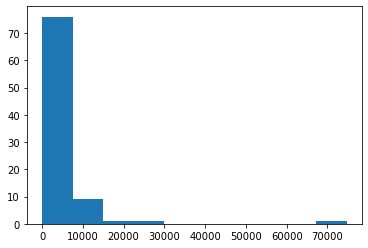

CPU times: user 118 ms, sys: 5.95 ms, total: 124 ms
Wall time: 123 ms


In [3]:
%%time

print (f'Smallest Weight: {min(tei.weight)}\nLargets Weight: {max(tei.weight)}')

fig, ax = plt.subplots()
plt.hist(tei['weight'])
plt.show()

### Scale Weights

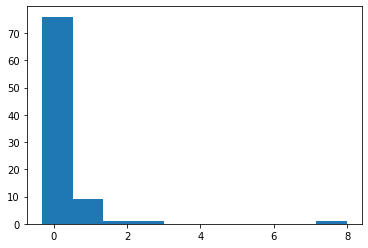

CPU times: user 108 ms, sys: 5.3 ms, total: 113 ms
Wall time: 112 ms


,source,target,weight
67,p,persRef,7.983747
71,persRef,hi,2.955332
21,div,div,1.713778


In [4]:
%%time

scaler = preprocessing.StandardScaler()
tei['weight'] = scaler.fit_transform(tei[['weight']])

fig, ax = plt.subplots()
plt.hist(tei['weight'])
plt.show()

tei.sort_values(by = 'weight', ascending = False).head(3)

## Create Network Object

In [5]:
%%time

G = nx.from_pandas_edgelist(tei, 
                            'source', 'target', 'weight')

# Add Nodes.
nodes = list( dict.fromkeys( tei['source'].values.tolist() + tei['target'].values.tolist()))
nodes = pd.DataFrame( nodes, columns = ['source'])
G.add_nodes_from(nodes)

# Add attributes & measurements.
nx.set_node_attributes(G, dict(G.degree(G.nodes())), 'degree')

betweenness = nx.betweenness_centrality(G)
eigenvector = nx.eigenvector_centrality(G)
degree_cent = nx.degree_centrality(G)

nx.set_node_attributes(G, betweenness, 'betweenness')
nx.set_node_attributes(G, eigenvector, 'eigenvector')
nx.set_node_attributes(G, degree_cent, 'degree_centrality')

# Find communities.
communities = community.greedy_modularity_communities(G)

modularity_dict = {}
for i, c in enumerate(communities):
    for name in c:
        modularity_dict[name] = i
        
nx.set_node_attributes(G, modularity_dict, 'modularity')

CPU times: user 6.73 ms, sys: 49 µs, total: 6.78 ms
Wall time: 6.82 ms


In [6]:
%%time

with open(abs_dir + "GitHub/dsg-mhs/d3/Network/TEI-Structure/jqa_tei-network.json", "w") as f:
    
    f.write( json.dumps( json_graph.node_link_data(G)))

CPU times: user 1.03 ms, sys: 897 µs, total: 1.92 ms
Wall time: 1.22 ms


## Convert Data for Hierarchical Format (Tree)

In [7]:
%%time

# Adjust fields to accomodate hierarchical structure.

# # TEI elements can have multiple parents in XML (appear within different elements) but not in Collapsible Tree.
# tei['idx'] = tei.index
# tei['source'] = tei['source'] + "_" + tei['idx'].astype(str)
# tei['target'] = tei['target'] + "_" + tei['idx'].astype(str)

# Add root.
tei_root = ['TEI', '', '']
tei.loc[len(tei)] = tei_root

tei.head()

CPU times: user 3.13 ms, sys: 595 µs, total: 3.73 ms
Wall time: 3.19 ms


,source,target,weight
0,TEI,teiHeader,-0.275618
1,TEI,text,-0.275618
2,bibl,<cyfunction Comment at 0x7fb4d1122790>,-0.311050
3,bibl,author,0.701031
4,bibl,date,0.736907


In [9]:
# %%time

# tei_json = {}

# """
# For source in TEI

# children = target

# """

# for idx, row in tei.iterrows():
#     node = row['source']
#     child = row['target']
    
#     if tei_json[node]:
#         tei_json[node]['children'] += child
        
#     else:
#         tei_json[node] = [{}]
#         tei_json[node]['name'] = child

KeyError: 'TEI'

In [8]:
%%time

tei.to_csv(abs_dir + 'GitHub/dsg-mhs/d3/Network/TEI-Structure/jqa_tei-structure.csv',
           sep = ',', index = False)

CPU times: user 2.39 ms, sys: 1.64 ms, total: 4.03 ms
Wall time: 2.91 ms
